In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

output_folder = r'output\SWaT\AnomalyTransformer\07012026_112129'
file_dir = os.path.join(output_folder, 'test_output.pkl')

# Load test_output.pkl
with open(file_dir, "rb") as f:
    test_output = pickle.load(f)

# Define index range
x = np.arange(len(test_output["A_True_Global"]))

# Identify true and predicted anomalies
true_anomalies = test_output.get("A_True_Global", np.zeros_like(x))
pred_anomalies = test_output.get("A_Pred_Global_bf", np.zeros_like(x))
anomalies = np.where(true_anomalies == 1)[0]
pred_anomalies_idx = np.where(pred_anomalies == 1)[0]

Predicted Anomalies index : 
 [ 15500  15521  15522 ... 438963 438964 438999]


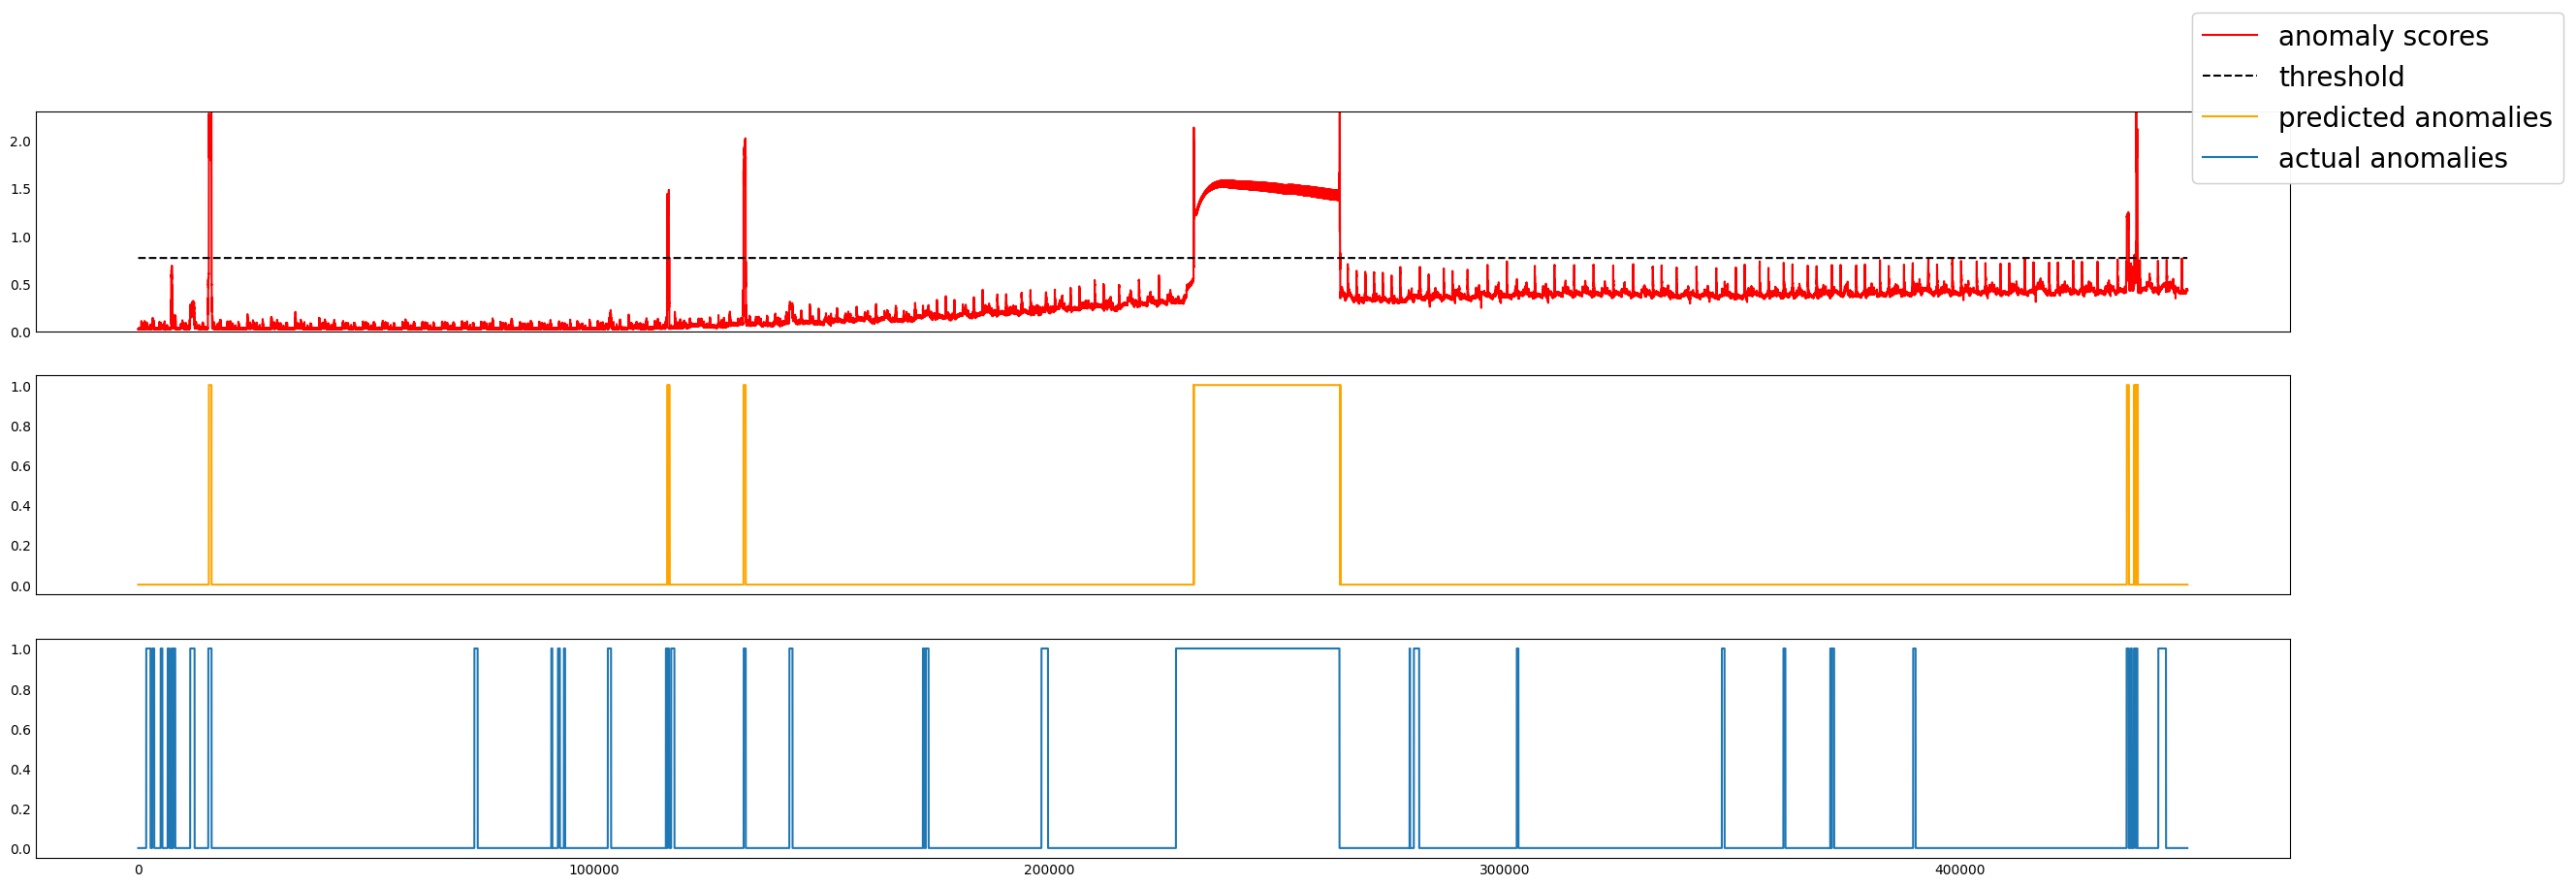

In [18]:
data_copy = test_output.copy()

print(f"Predicted Anomalies index : \n {pred_anomalies_idx}")
fig, axs = plt.subplots(3, figsize=(30, 10), sharex=True)

axs[0].plot(data_copy["A_Score_Global"], c="r", label="anomaly scores")
axs[0].plot(data_copy["Thresh_Global_bf"], linestyle="dashed", c="black", label="threshold")
axs[1].plot(data_copy["A_Pred_Global_bf"], label="predicted anomalies", c="orange")
axs[2].plot(data_copy["A_True_Global"], label="actual anomalies")

axs[0].set_ylim([0, 3 * np.mean(data_copy["Thresh_Global_bf"].values)])
# axs[0].set_ylim([0 , 0.1])
fig.legend(prop={"size": 20})
# plt.show()


# Y축 범위 설정
axs[0].set_ylim([0, 3 * np.mean(data_copy["Thresh_Global_bf"].values)])

# ---------------------------------------------------------
# [수정된 부분] 모든 서브플롯(axs)에 대해 눈금 선 및 격자 제거 설정
# ---------------------------------------------------------
for ax in axs:
    # 1. 배경의 수평/수직 격자(Grid) 끄기
    ax.grid(False) 
    
    # 2. 축 위의 눈금 표시(작은 작대기) 길이 0으로 설정 (안 보이게 함)
    # axis='both': x, y축 모두 적용
    # which='both': 주 눈금(major)과 보조 눈금(minor) 모두 적용
    ax.tick_params(axis='both', which='both', length=0)

fig.legend(prop={"size": 20})
plt.show()

In [19]:
data_copy = test_output.drop(columns=['A_Score_Global', 'Thresh_Global_bf'])
cols = [c for c in data_copy.columns if not (c.startswith('Thresh_') or c.startswith('A_Pred_'))]
data_copy = data_copy[cols]

num_cols = data_copy.shape[1]

fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(20, num_cols), sharex=True)
fig.tight_layout(pad=3.0)

for i, col in enumerate(data_copy.columns):
    ax = axes[i] if num_cols > 1 else axes
    ax.plot(data_copy.index, data_copy[col], color='gray' if 'A_Score' not in col else 'red')
    ax.set_title(col, fontsize=10, pad=3, loc='left')
    
    # ax.set_ylim(-0.1, 1.2)
    ax.grid(True)
            
plt.xlabel("Index")
plt.show()

KeyboardInterrupt: 

In [ ]:
# # Replicate the user's data manipulation
# data_copy = test_output.drop(columns=['A_Score_Global', 'Thresh_Global_bf'])
# cols = [c for c in data_copy.columns if not (c.startswith('Thresh_') or c.startswith('A_Pred_'))]
# data_copy = data_copy[cols]

# num_cols = data_copy.shape[1]

# # Create the figure with subplots
# fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(20, num_cols), sharex=True)

# # Adjust subplot parameters to remove vertical space
# plt.subplots_adjust(hspace=0)

# # Plotting loop
# for i, col in enumerate(data_copy.columns):
#     ax = axes[i] if num_cols > 1 else axes
#     ax.plot(data_copy.index, data_copy[col], color='gray' if 'A_Score' not in col else 'red')
#     # Place sensor name as text inside the plot, non-obtrusively
#     ax.text(0.01, 0.9, col, transform=ax.transAxes, fontsize=10, fontweight='bold')
#     ax.set_ylim(-0.1, 1.5)
#     ax.grid(True)
    
# # Set a single xlabel for the shared x-axis on the last subplot
# axes[-1].set_xlabel("Index")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_anomaly_scores(file_dir, time_index, window_size=None, original_index=False):
    # 1. 데이터 로드
    df = pd.read_pickle(file_dir)

    # 2. index 보정
    if original_index:
        if window_size is None:
            raise ValueError("original_index=True이면 window_size를 반드시 지정해야 합니다.")
        time_index -= window_size

    if time_index < 0 or time_index >= len(df):
        raise IndexError(f"유효하지 않은 시점입니다. 허용 범위: 0 ~ {len(df)-1}")

    # 3. anomaly score 추출
    if not df.filter(like='A_Score_').empty:
        feature_scores = df.filter(like='A_Score_').iloc[time_index]
    elif not df.filter(like='err_scores').empty:
        feature_scores = df.filter(like='err_scores').iloc[time_index]
    else:
        raise ValueError("DataFrame에 'A_Score_' 또는 'err_scores' 컬럼이 없습니다.")

    # 🔹 3-1. Global anomaly 점수 제거
    feature_scores = feature_scores[[col for col in feature_scores.index if "Global" not in col]]

    # 4. 음수 보정
    min_val = feature_scores.min()
    if min_val < 0:
        feature_scores = feature_scores + abs(min_val)

    # 5. 내림차순 정렬
    sorted_scores = feature_scores.sort_values(ascending=False)

    # 6. 라벨 정리 (숫자만 추출 및 +1 처리)
    clean_labels = []
    for label in sorted_scores.index:
        # 접두사 제거 (예: 'A_Score_0' -> '0')
        cleaned = label.replace("A_Score_", "").replace("err_scores_", "")
        
        # 숫자로 변환하여 +1 더한 후, 다시 문자열로 변환
        try:
            numbered_label = str(int(cleaned) + 1)
        except ValueError:
            # 숫자가 아닌 문자열이 남은 경우 (혹시 모를 예외 처리), 그대로 사용
            numbered_label = cleaned
            
        clean_labels.append(numbered_label)
        
    # 7. 색상 지정 (상위 3개는 빨간색, 나머지는 원래 colormap)
    base_colors = plt.cm.Blues_r(range(len(sorted_scores)))
    # 상위 3개 (0, 1, 2 인덱스)를 빨간색으로 지정
    colors = ['red' if i < 3 else base_colors[i] for i in range(len(sorted_scores))]

    # 8. 시각화 (논문용 퀄리티)
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(sorted_scores)), sorted_scores.values, color=colors)

    plt.xticks(range(len(sorted_scores)), clean_labels, rotation=90, fontsize=12)
    plt.yticks(fontsize=12)

    # y축 격자선 추가
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 불필요한 테두리 제거
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

    return sorted_scores

In [ ]:
file_dir = file_dir
index = 1200
sorted_scores = plot_anomaly_scores(file_dir, index)

print("\nTop 5 Sensors at this time step:")
print(sorted_scores.head(5))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Matplotlib 경고 무시
warnings.filterwarnings("ignore", "The figure layout has not been constrained") 

def plot_top_anomalous_sensors_top3_scatter(data_df):
    """
    실제 이상 구간(A_True_Global=1)에서 Anomaly Score가 가장 높은 상위 3개 센서의 번호를 점 그래프로 시각화합니다.
    (선 연결 없이 마커만 표시)
    
    색상 매핑:
    - 1순위: 빨간색 (red)
    - 2순위: 초록색 (green)
    - 3순위: 파란색 (blue)

    Args:
        data_df (pd.DataFrame): test_output.pkl에서 로드된 DataFrame.
    """
    
    # 1. Feature Score 컬럼 동적 식별 및 센서 개수 확인
    score_cols = [col for col in data_df.columns if col.startswith('A_Score_') and 'Global' not in col]
    K = len(score_cols)
    
    if K == 0:
        print("경고: 'A_Score_0', 'A_Score_1', ... 형태의 채널별 Anomaly Score 컬럼을 찾을 수 없습니다.")
        return

    # 2. 실제 이상 시점(A_True_Global = 1)의 데이터만 필터링
    anomalous_data = data_df[data_df["A_True_Global"] == 1].copy()
    
    if anomalous_data.empty:
        print("경고: 실제 이상 구간(A_True_Global = 1)이 없어 플로팅할 데이터가 없습니다.")
        return

    # 3. 각 이상 시점에서 상위 3개 Anomaly Score를 기록한 센서 번호(0-based index) 추출
    anomaly_scores_df = anomalous_data[score_cols]

    def get_top_n_sensors_index(row, n=3):
        top_n_cols = row.nlargest(n).index.tolist()
        return [int(col.split('_')[-1]) for col in top_n_cols]

    # 모든 이상 시점에 대해 상위 3개 센서 인덱스 추출
    top_sensors_list = anomaly_scores_df.apply(get_top_n_sensors_index, axis=1).tolist()

    # 상위 1, 2, 3위 센서 인덱스를 분리하고, 1부터 시작하도록 +1 보정
    
    # Priority 1 센서 (빨간색)
    y_top1 = np.array([item[0] for item in top_sensors_list]) + 1
    
    # Priority 2 센서 (초록색)
    y_top2 = np.array([item[1] if len(item) > 1 else np.nan for item in top_sensors_list]) + 1
    
    # Priority 3 센서 (파란색)
    y_top3 = np.array([item[2] if len(item) > 2 else np.nan for item in top_sensors_list]) + 1

    # X축: 실제 이상이 발생한 시점의 DataFrame Index
    x_indices = anomalous_data.index.values

    # 4. 시각화 (점 그래프로 수정 및 최적화 설정 적용)
    
    try:
        plt.rcParams['font.family'] = 'Times New Roman'
    except:
        plt.rcParams['font.family'] = 'serif'
        
    plt.rcParams['figure.dpi'] = 300
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, ax = plt.subplots(figsize=(20, 7))

    # 🔴 우선순위 1번 센서 (빨간색)
    ax.plot(x_indices, y_top1, color='red', marker='o', linestyle='None', markersize=7, label='Priority 1 Sensor (Red)')

    # 🟢 우선순위 2번 센서 (초록색)
    ax.plot(x_indices, y_top2, color='green', marker='x', linestyle='None', markersize=7, label='Priority 2 Sensor (Green)')
    
    # 🔵 우선순위 3번 센서 (파란색)
    ax.plot(x_indices, y_top3, color='blue', marker='^', linestyle='None', markersize=7, label='Priority 3 Sensor (Blue)')

    # Y축 설정 (센서 번호)
    ax.set_yticks(np.arange(1, K + 1))
    ax.set_ylim([0.5, K + 0.5]) 
    ax.tick_params(axis='y', labelsize=12)
    
    # X축 설정
    ax.tick_params(axis='x', rotation=45, labelsize=12)

    # 레이블 및 제목 설정
    ax.set_xlabel('Time Index (Actual Anomaly Occurrences)', fontsize=14, labelpad=10)
    ax.set_ylabel('Sensor Number (1 to {})'.format(K), fontsize=14)
    ax.set_title('Top 3 Most Anomalous Sensors at True Anomaly Timesteps (Scatter Plot)', fontsize=16, pad=15)

    # 그리드 및 범례 설정
    ax.grid(axis='y', linestyle=':', alpha=0.7) # Y축 격자만 남겨 센서 구분을 명확히 함
    ax.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
    
    # 불필요한 테두리 제거
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# ----------------- #
# 함수 호출 예시
# ----------------- #

# # 사용자 환경에서 'data_copy' 변수가 로드되어 있다고 가정하고 아래 함수를 호출하여 사용합니다.
# # plot_top_anomalous_sensors_top3_scatter(data_copy)

In [ ]:
plot_top_anomalous_sensors_top3_scatter(data_copy)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Matplotlib 경고 무시
warnings.filterwarnings("ignore", "The figure layout has not been constrained") 
warnings.filterwarnings("ignore", "Using a non-supported format for `set_xticklabels`")

def plot_anomaly_priority_heatmap(data_df, K=15, skip_interval=100):
    """
    실제 이상 구간(A_True_Global=1)에서 Anomaly Score 순위 변화를 히트맵으로 시각화합니다.
    이 코드는 모든 센서의 우선순위 변화를 시각화하며 다음 조건을 충족합니다:
    - X축: 실제 이상 시점의 인덱스.
    - Y축: 센서 번호 (1번이 가장 아래, K번이 가장 위).
    - 색상: Rank 1 (최고 점수)은 빨간색, Rank K (최저 점수)는 파란색.
    
    Args:
        data_df (pd.DataFrame): test_output.pkl에서 로드된 DataFrame.
        K (int): 센서의 총 개수. (예시: 15)
        skip_interval (int): X축 레이블이 너무 많아지는 것을 방지하기 위한 레이블 표시 간격.
    """
    
    # 1. Feature Score 컬럼 동적 식별 및 K 값 조정
    score_cols = [col for col in data_df.columns if col.startswith('A_Score_') and 'Global' not in col]
    num_sensors = len(score_cols)
    
    if K != num_sensors:
        if K != 15:
             print(f"경고: 입력된 K ({K})가 실제 센서 수 ({num_sensors})와 다릅니다. 실제 센서 수를 사용합니다.")
        K = num_sensors
    
    if num_sensors == 0:
        print("경고: 'A_Score_0', 'A_Score_1', ... 형태의 채널별 Anomaly Score 컬럼을 찾을 수 없습니다.")
        return

    # 2. 실제 이상 시점(A_True_Global = 1)의 데이터만 필터링
    anomalous_data = data_df[data_df["A_True_Global"] == 1].copy()
    
    if anomalous_data.empty:
        print("경고: 실제 이상 구간(A_True_Global = 1)이 없어 플로팅할 데이터가 없습니다.")
        return

    # 3. 우선순위(Rank) 행렬 계산
    # rank(ascending=False)를 사용하여 가장 큰 값(가장 높은 Anomaly Score)에 1순위(Rank 1)를 부여
    anomaly_scores_df = anomalous_data[score_cols]
    priority_matrix_df = anomaly_scores_df.rank(axis=1, ascending=False, method='first')
    
    # 히트맵을 위해 NumPy 배열로 변환 (Shape: (이상 시점 수, 센서 개수))
    priority_matrix = priority_matrix_df.to_numpy() 
    
    # Y축 레이블 (센서 번호 1부터 시작)
    sensor_labels = [str(i + 1) for i in range(num_sensors)]
    
    # X축 레이블 (이상 시점 인덱스)
    time_indices = anomalous_data.index.values

    # 4. 시각화 (히트맵)
    
    try:
        plt.rcParams['font.family'] = 'Times New Roman'
    except:
        plt.rcParams['font.family'] = 'serif'
        
    plt.rcParams['figure.dpi'] = 300
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 이미지 크기를 이상 시점의 개수에 따라 유동적으로 조정
    fig_width = max(len(time_indices) / 10, 15)
    fig, ax = plt.subplots(figsize=(fig_width, 8))

    # Heatmap 플롯
    # 'RdBu_r'은 낮은 값(Rank 1)에 빨간색을, 높은 값(Rank K)에 파란색을 매핑합니다.
    cax = ax.imshow(
        priority_matrix.T,
        aspect='auto', 
        cmap='RdBu', # Rank 1 (낮은 값) -> 빨간색
        vmin=1, 
        vmax=num_sensors,
        origin='lower' # 1번 센서(인덱스 0)를 플롯의 가장 아래에 위치하도록 강제
    )

    # 축 설정
    
    # Y축 (센서 번호)
    ax.set_yticks(np.arange(num_sensors))
    ax.set_yticklabels(sensor_labels, fontsize=12)
    ax.set_ylabel('Sensor Number', fontsize=14, labelpad=10)
    
    # X축 (시간 인덱스)
    num_timesteps = len(time_indices)
    
    # X축 눈금 및 레이블 설정 (간격 조정)
    tick_positions = np.arange(0, num_timesteps, skip_interval)
    tick_labels = time_indices[tick_positions] if len(time_indices) > 0 else []

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=12)
    ax.set_xlabel('Time Index (Actual Anomaly Occurrences)', fontsize=14, labelpad=10)
    
    # 컬러바 설정
    cbar_ticks = np.arange(1, num_sensors + 1, max(1, num_sensors // 10))
    cbar = fig.colorbar(cax, ticks=cbar_ticks)
    cbar.set_label('Anomaly Priority Rank (1 = Highest Score)', rotation=270, labelpad=20, fontsize=14)
    
    # **수정된 부분:** 컬러바의 Y축을 반전시켜 빨간색(Rank 1)이 위쪽에 오도록 합니다.
    cbar.ax.invert_yaxis() 
    
    # 제목 설정
    ax.set_title(f'Sensor Priority Rank Change During True Anomalies (K={num_sensors})', fontsize=16, pad=15)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_anomaly_priority_heatmap(data_copy, K=15, skip_interval=500)

In [ ]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm

def plot_anomaly_priority_heatmap_topk(data_df, K=15, skip_interval=100, TOP_K=3):
    """
    실제 이상 구간(A_True_Global=1)에서 Anomaly Score 순위 변화를 히트맵으로 시각화하되,
    각 시점별 Rank 상위 TOP_K 센서만 색으로 강조합니다.
    
    - Rank가 높을수록(=1에 가까울수록) 더 진한 색으로 표현.
    - Top-K 안에 들지 못한 센서는 NaN 처리하여 흰색(또는 매우 옅게)으로 보이게 합니다.
    """

    # 1. Feature Score 컬럼 동적 식별 및 K 값 조정
    score_cols = [col for col in data_df.columns 
                  if col.startswith('A_Score_') and 'Global' not in col]
    num_sensors = len(score_cols)
    
    if K != num_sensors:
        if K != 15:
            print(f"경고: 입력된 K ({K})가 실제 센서 수 ({num_sensors})와 다릅니다. 실제 센서 수를 사용합니다.")
        K = num_sensors
    
    if num_sensors == 0:
        print("경고: 'A_Score_0', 'A_Score_1', ... 형태의 채널별 Anomaly Score 컬럼을 찾을 수 없습니다.")
        return

    # 2. 실제 이상 시점(A_True_Global = 1)의 데이터만 필터링
    anomalous_data = data_df[data_df["A_True_Global"] == 1].copy()
    
    if anomalous_data.empty:
        print("경고: 실제 이상 구간(A_True_Global = 1)이 없어 플로팅할 데이터가 없습니다.")
        return

    # 3. 우선순위(Rank) 행렬 계산
    anomaly_scores_df = anomalous_data[score_cols]
    priority_matrix_df = anomaly_scores_df.rank(axis=1, ascending=False, method='first')
    
    # 히트맵용 NumPy 배열
    priority_matrix = priority_matrix_df.to_numpy().astype(float)

    # 3-1. TOP_K 밖의 값은 NaN으로 만들어서 색 제거
    priority_matrix[priority_matrix > TOP_K] = np.nan

    # Y축 레이블 (센서 번호)
    sensor_labels = [col.replace('A_Score_', '') for col in score_cols]
    
    # X축 레이블 (이상 시점 인덱스)
    time_indices = anomalous_data.index.values

    # 4. 시각화 설정
    try:
        plt.rcParams['font.family'] = 'Times New Roman'
    except:
        plt.rcParams['font.family'] = 'serif'
        
    plt.rcParams['figure.dpi'] = 300
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig_width = max(len(time_indices) / 10, 15)
    fig, ax = plt.subplots(figsize=(fig_width, 12))

    # ⭐ 컬러맵: plt.get_cmap 사용 (Rank 1이 가장 진한 빨강)
    base_cmap = plt.get_cmap('Reds_r', TOP_K)
    cmap = base_cmap
    cmap.set_bad('white')  # NaN은 흰색

    #   RdYlBu_r: Red → Yellow → Blue (reversed)
    # base_cmap = plt.get_cmap('RdYlBu_r', TOP_K)  # TOP_K개의 구간으로 나눈 colormap
    # cmap = base_cmap
    # cmap.set_bad('white')  # NaN은 흰색 

    # ⭐ Rank별 색을 딱딱 나누는 BoundaryNorm
    bounds = np.arange(0.5, TOP_K + 1.5, 1)  # 0.5~1.5->1, 1.5~2.5->2, ...
    norm = BoundaryNorm(bounds, cmap.N)

    # Heatmap 플롯 (Top-K만 색)
    cax = ax.imshow(
        priority_matrix.T,
        aspect='auto', 
        cmap=cmap,
        norm=norm,
        origin='lower'
    )

    # Y축 (센서 번호)
    num_timesteps = len(time_indices)
    num_sensors = len(score_cols)

    ax.set_yticks(np.arange(num_sensors))
    ax.set_yticklabels(sensor_labels, fontsize=12)
    ax.set_ylabel('Sensor Number', fontsize=14, labelpad=10)
    
    # X축 (시간 인덱스)
    tick_positions = np.arange(0, num_timesteps, skip_interval)
    if num_timesteps > 0 and (len(tick_positions) == 0 or tick_positions[0] != 0):
        tick_positions = np.insert(tick_positions, 0, 0)
    tick_labels = time_indices[tick_positions] if len(time_indices) > 0 else []

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=12)
    ax.set_xlabel('Time Index (Actual Anomaly Occurrences)', fontsize=14, labelpad=10)
    
    # 컬러바 설정 (1 ~ TOP_K)
    cbar_ticks = np.arange(1, TOP_K + 1)
    cbar = fig.colorbar(cax, ticks=cbar_ticks, boundaries=bounds)
    cbar.set_label(
        f'Anomaly Priority Rank (Top-{TOP_K})',
        rotation=270, labelpad=20, fontsize=14
    )
    cbar.ax.invert_yaxis()  # Rank 1이 위쪽
    
    ax.set_title(
        f'Sensor Priority (Only Top-{TOP_K}) During True Anomalies (Total K={num_sensors})',
        fontsize=16, pad=15
    )
    
    plt.tight_layout()
    plt.show()

In [ ]:
# 각 시점별 Top-k 센서만 강조한 히트맵
plot_anomaly_priority_heatmap_topk(data_copy, K=15, skip_interval=100, TOP_K=5)

In [ ]:
def plot_anomaly_scores_during_true_anomalies(data_df, K=15, skip_interval=100):
    """
    실제 이상 구간(A_True_Global = 1)에서 각 센서의 anomaly score를
    하나의 그래프에 겹쳐서 그립니다.
    
    - X축: 실제 이상 시점의 인덱스
    - Y축: anomaly score
    - 센서들은 서로 다른 색으로 표현
    """

    # 1. 채널별 anomaly score 컬럼 찾기
    score_cols = [
        col for col in data_df.columns 
        if col.startswith('A_Score_') and 'Global' not in col
    ]
    num_sensors = len(score_cols)
    
    if num_sensors == 0:
        print("경고: 'A_Score_0', 'A_Score_1', ... 형태의 채널별 Anomaly Score 컬럼을 찾을 수 없습니다.")
        return
    
    if K != num_sensors:
        if K != 15:
            print(f"경고: 입력된 K ({K})가 실제 센서 수 ({num_sensors})와 다릅니다. 실제 센서 수를 사용합니다.")
        K = num_sensors

    # 2. 실제 이상 시점만 필터링
    anomalous_data = data_df[data_df["A_True_Global"] == 1].copy()
    
    if anomalous_data.empty:
        print("경고: 실제 이상 구간(A_True_Global = 1)이 없어 플로팅할 데이터가 없습니다.")
        return

    # X축: 이상 시점 index (원래 인덱스 값 그대로 사용)
    time_indices = anomalous_data.index.values
    num_timesteps = len(time_indices)

    # 3. 스타일 설정
    try:
        plt.rcParams['font.family'] = 'Times New Roman'
    except:
        plt.rcParams['font.family'] = 'serif'
        
    plt.rcParams['figure.dpi'] = 300
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 🔧 이전처럼 x 길이에 비례해서 width를 키우지 말고,
    #    어느 정도 고정된 큰 사이즈로 세로를 넉넉하게 잡음
    fig, ax = plt.subplots(figsize=(20, 8))  # 가로 20, 세로 8 정도로 크게

    # 4. 각 센서별 anomaly score 라인 그리기
    cmap = plt.get_cmap('tab20', num_sensors)
    
    for idx, col in enumerate(score_cols):
        scores = anomalous_data[col].values
        sensor_id = col.replace('A_Score_', '')  # 예: 'A_Score_3' -> '3'
        
        ax.plot(
            time_indices,
            scores,
            label=f'Sensor {sensor_id}',
            color=cmap(idx),
            linewidth=1
        )

    # 5. y축 스케일을 살짝 확대해서 납작해 보이지 않게
    all_scores = anomalous_data[score_cols].values
    ymin = float(np.nanmin(all_scores))
    ymax = float(np.nanmax(all_scores))
    if ymin == ymax:
        # 전부 같은 값이면 약간 패딩
        ymin -= 1
        ymax += 1
    else:
        margin = 0.1 * (ymax - ymin)
        ymin -= margin
        ymax += margin
    ax.set_ylim(ymin, ymax)

    # 6. X축 눈금 설정 (실제 인덱스 값 기준)
    if num_timesteps > 0:
        pos_indices = np.arange(0, num_timesteps, skip_interval)
        if len(pos_indices) == 0 or pos_indices[0] != 0:
            pos_indices = np.insert(pos_indices, 0, 0)

        tick_positions = time_indices[pos_indices]
        tick_labels = time_indices[pos_indices]
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=12)

    ax.set_xlabel('Time Index (Actual Anomaly Occurrences)', fontsize=14)
    ax.set_ylabel('Anomaly Score', fontsize=14)
    ax.set_title(
        f'Channel-wise Anomaly Scores During True Anomalies (K={num_sensors})',
        fontsize=16, pad=10
    )
    
    # 범례는 오른쪽 밖으로
    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=10
    )
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_anomaly_scores_during_true_anomalies(data_copy, K=15, skip_interval=100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

def plot_anomaly_priority_heatmap_topk_v2(
    data_df,
    K=15,
    skip_interval=100,
    TOP_K=3,
    row_height=0.6,
    min_height=8,
    max_height=15,
    focus_time=None,    # 중심 시점 (원래 index)
    focus_window=None,  # 그 주변으로 포함할 step 수 (예: 200이면 ±100)
):
    """
    실제 이상 구간(A_True_Global=1)에서 Anomaly Score 순위 변화를 히트맵으로 시각화하되,
    각 시점별 Rank 상위 TOP_K 센서만 색으로 강조합니다.

    + 추가 기능:
      - focus_time, focus_window를 주면 해당 시점 주변 window만 잘라서 그림.
        예) focus_time=1850, focus_window=200 → index [1750, 1950] 구간만 표시.

    색 구성:
      - Rank마다 서로 다른 계열의 색 (tab 계열 고정 색).
      - Top-K 밖: NaN → 흰색으로 비워진 영역처럼 표시.
    """

    # 1. Feature Score 컬럼 동적 식별 및 K 값 조정
    score_cols = [
        col for col in data_df.columns
        if col.startswith('A_Score_') and 'Global' not in col
    ]
    num_sensors = len(score_cols)
    
    if num_sensors == 0:
        print("경고: 'A_Score_0', 'A_Score_1', ... 형태의 채널별 Anomaly Score 컬럼을 찾을 수 없습니다.")
        return

    if K != num_sensors:
        if K != 15:
            print(f"경고: 입력된 K ({K})가 실제 센서 수 ({num_sensors})와 다릅니다. 실제 센서 수를 사용합니다.")
        K = num_sensors

    # 2. 실제 이상 시점(A_True_Global = 1)의 데이터만 필터링
    anomalous_data = data_df[data_df["A_True_Global"] == 1].copy()
    if anomalous_data.empty:
        print("경고: 실제 이상 구간(A_True_Global = 1)이 없어 플로팅할 데이터가 없습니다.")
        return

    # ✅ 2-1. 특정 시점 주변 window만 보고 싶은 경우: 여기서 한 번 더 필터링
    if (focus_time is not None) and (focus_window is not None):
        half = focus_window // 2
        start_t = focus_time - half
        end_t = focus_time + half
        window_data = anomalous_data[
            (anomalous_data.index >= start_t) &
            (anomalous_data.index <= end_t)
        ]
        if window_data.empty:
            print(f"경고: 지정한 window에 (index ∈ [{start_t}, {end_t}]) 이상구간이 없습니다.")
            return
        anomalous_data = window_data

    # 3. 우선순위(Rank) 행렬 계산
    anomaly_scores_df = anomalous_data[score_cols]
    priority_matrix_df = anomaly_scores_df.rank(axis=1, ascending=False, method='first')
    
    # 히트맵용 NumPy 배열
    priority_matrix = priority_matrix_df.to_numpy().astype(float)

    # 3-1. TOP_K 밖의 값은 NaN으로 만들어서 색 제거
    priority_matrix[priority_matrix > TOP_K] = np.nan

    # Y축 레이블 (센서 번호)
    sensor_labels = [int(col.replace('A_Score_', '')) + 1 for col in score_cols]
    
    # X축 레이블 (이상 시점 인덱스)
    time_indices = anomalous_data.index.values
    num_timesteps = len(time_indices)

    # 4. 시각화 설정
    try:
        plt.rcParams['font.family'] = 'Times New Roman'
    except:
        plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.dpi'] = 300
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig_width = max(num_timesteps / 10, 15)
    fig, ax = plt.subplots(figsize=(fig_width, 4))

    # 5. Rank별 팔레트 정의 (tab 계열 고정 색)
    base_cmap = plt.get_cmap('Reds_r', TOP_K) 
    cmap = base_cmap 
    cmap.set_bad('white') # NaN은 흰색

    bounds = np.arange(0.5, TOP_K + 1.5, 1)
    norm = BoundaryNorm(bounds, cmap.N)

    # 6. Heatmap 플롯
    cax = ax.imshow(
        priority_matrix.T,
        aspect="auto",
        cmap=cmap,
        norm=norm,
        origin="lower",
    )

    # Y축 (센서 번호)
    ax.set_yticks(np.arange(num_sensors))
    ax.set_yticklabels(sensor_labels, fontsize=9)
    ax.set_ylabel("Sensor Number", fontsize=10, labelpad=10)
    
    # X축 (시간 인덱스)
    tick_positions = np.arange(0, num_timesteps, skip_interval)
    if num_timesteps > 0 and (len(tick_positions) == 0 or tick_positions[0] != 0):
        tick_positions = np.insert(tick_positions, 0, 0)
    tick_labels = time_indices[tick_positions] if len(time_indices) > 0 else []

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=9)
    ax.set_xlabel("Time Index", fontsize=10, labelpad=10)
    
    # 컬러바 (1 ~ TOP_K)
    cbar_ticks = np.arange(1, TOP_K + 1)
    cbar = fig.colorbar(cax, ticks=cbar_ticks, boundaries=bounds)
    cbar.set_label(
        f"Anomaly Priority Rank (Top-{TOP_K})",
        rotation=270,
        labelpad=8,
        fontsize=8,
    )
    cbar.ax.invert_yaxis()

    # 제목에 window 정보도 살짝 표시
    window_info = ""
    if (focus_time is not None) and (focus_window is not None):
        window_info = f" | Range [{start_t} ~ {end_t}]"

    ax.set_title(
        f"Sensor Priority (Only Top-{TOP_K}) During True Anomalies {window_info}",
        fontsize=12,
        pad=15,
    )
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_anomaly_priority_heatmap_topk_v2(
    data_copy,
    K=15,
    TOP_K=5,
    skip_interval=20,     # window가 작으니 더 촘촘하게
    focus_time=1533,      # 기준 시점
    focus_window=100,     # 전체 window 폭 (±50)
    row_height=0.01,
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import BoundaryNorm

def plot_anomaly_priority_heatmap_topk(data_df, K=15, skip_interval=100, TOP_K=3):
    """
    실제 이상 구간(A_True_Global=1)에서:
    1. 히트맵: 각 시점별 Anomaly Score Rank 상위 TOP_K 센서 시각화
    2. 음영(회색): 모델이 예측한 이상 구간(A_Pred_Global_bf=1) 시각화
    
    핵심: 히트맵과 음영 모두 'anomalous_data'라는 동일한 부분집합을 기준으로 그려 X축을 일치시킴.
    """

    # 1. Feature Score 컬럼 동적 식별
    score_cols = [col for col in data_df.columns 
                  if col.startswith('A_Score_') and 'Global' not in col]
    num_sensors = len(score_cols)
    
    # K 값 보정
    if K != num_sensors:
        K = num_sensors
    
    if num_sensors == 0:
        print("경고: Anomaly Score 컬럼을 찾을 수 없습니다.")
        return

    # =========================================================================
    # [중요] 2. 실제 이상 시점(A_True_Global = 1)의 데이터만 필터링 (Deep Copy)
    # =========================================================================
    # 여기서 만든 anomalous_data가 X축의 기준(0 ~ N-1)이 됩니다.
    anomalous_data = data_df[data_df["A_True_Global"] == 1].copy()
    
    if anomalous_data.empty:
        print("경고: 실제 이상 구간(A_True_Global = 1)이 없습니다.")
        return

    # 3. 우선순위(Rank) 행렬 계산
    # anomalous_data 내부에서 score를 뽑았으므로 길이(X축)가 동일함이 보장됨
    anomaly_scores_df = anomalous_data[score_cols]
    priority_matrix_df = anomaly_scores_df.rank(axis=1, ascending=False, method='first')
    
    # 히트맵용 NumPy 배열
    priority_matrix = priority_matrix_df.to_numpy().astype(float)

    # 3-1. TOP_K 밖의 값은 NaN 처리
    priority_matrix[priority_matrix > TOP_K] = np.nan

    # 라벨링 준비
    sensor_labels = [col.replace('A_Score_', '') for col in score_cols]
    time_indices = anomalous_data.index.values # 실제 시간 인덱스 (X축 라벨용)

    # 4. 시각화 설정
    plt.rcParams['figure.dpi'] = 300
    plt.style.use('seaborn-v0_8-whitegrid')
    try:
        plt.rcParams['font.family'] = 'Times New Roman'
    except:
        plt.rcParams['font.family'] = 'serif'
    
    fig_width = max(len(time_indices) / 10, 15)
    fig, ax = plt.subplots(figsize=(fig_width, 12))

    # 컬러맵 설정
    base_cmap = plt.get_cmap('Reds_r', TOP_K)
    cmap = base_cmap
    cmap.set_bad('white')
    bounds = np.arange(0.5, TOP_K + 1.5, 1)
    norm = BoundaryNorm(bounds, cmap.N)

    # =========================================================================
    # [히트맵 그리기]
    # imshow는 X축을 0부터 데이터 길이(N)까지 정수로 배치합니다.
    # extent를 명시하지 않으면 기본적으로 x는 -0.5 ~ N-0.5 범위를 가집니다.
    # =========================================================================
    cax = ax.imshow(
        priority_matrix.T,
        aspect='auto', 
        cmap=cmap,
        norm=norm,
        origin='lower',
        interpolation='nearest' 
    )

    # =========================================================================
    # [음영 처리] X축 불일치 해결
    # 반드시 위에서 필터링한 'anomalous_data'에서 예측값을 가져와야 합니다.
    # =========================================================================
    if "A_Pred_Global_bf" in anomalous_data.columns:
        # 1. 필터링된 데이터프레임에서 값 추출 (전체 data_df 아님!)
        preds = anomalous_data["A_Pred_Global_bf"].values.astype(int)
        
        # 2. 연속 구간 찾기
        # preds 배열의 인덱스(0, 1, 2...)는 heatmap의 X축(0, 1, 2...)과 1:1 대응됩니다.
        preds_padded = np.concatenate(([0], preds, [0]))
        diffs = np.diff(preds_padded)
        starts = np.where(diffs == 1)[0]
        ends = np.where(diffs == -1)[0]
        
        # 3. 구간 그리기
        # imshow의 픽셀 i는 [i-0.5, i+0.5] 영역을 차지합니다.
        # 따라서 start부터 end 직전까지 칠하려면 [start-0.5, end-0.5]로 설정합니다.
        for start, end in zip(starts, ends):
            ax.axvspan(start - 0.5, end - 0.5, color='yellow', alpha=0.1, zorder=10)
    else:
        print("경고: 'A_Pred_Global_bf' 컬럼이 없어 예측 구간 표시를 생략합니다.")

    # Y축 설정
    ax.set_yticks(np.arange(num_sensors))
    ax.set_yticklabels(sensor_labels, fontsize=12)
    ax.set_ylabel('Sensor Number', fontsize=14, labelpad=10)
    
    # X축 설정 (Tick Label만 실제 시간 인덱스로 매핑)
    num_timesteps = len(time_indices)
    tick_positions = np.arange(0, num_timesteps, skip_interval)
    
    # 0번 인덱스 강제 포함
    if num_timesteps > 0 and (len(tick_positions) == 0 or tick_positions[0] != 0):
        tick_positions = np.insert(tick_positions, 0, 0)
        
    tick_labels = time_indices[tick_positions] if len(time_indices) > 0 else []

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=12)
    
    # X축 범위를 데이터 끝에 딱 맞춤 (흰 여백 제거)
    ax.set_xlim(-0.5, num_timesteps - 0.5)
    
    ax.set_xlabel('Time Index (True Anomaly Sections)', fontsize=14, labelpad=10)
    
    # 컬러바
    cbar_ticks = np.arange(1, TOP_K + 1)
    cbar = fig.colorbar(cax, ticks=cbar_ticks, boundaries=bounds)
    cbar.set_label(f'Anomaly Priority Rank (Top-{TOP_K})', rotation=270, labelpad=20, fontsize=14)
    cbar.ax.invert_yaxis()
    
    ax.set_title(f'Sensor Priority (Top-{TOP_K}) During True Anomalies\n(Gray Shade: Model Predicted Anomaly)', fontsize=16, pad=15)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_anomaly_priority_heatmap_topk(test_output, K=15, skip_interval=100, TOP_K=5)